<a href="https://colab.research.google.com/github/schadracknkulu2-max/ML_BAC4_UMK/blob/main/NDALA_TP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

##Importation du Dataset Excel

In [8]:
df = pd.read_excel("/content/tickets_metalkol.xlsx")
df.head()

,ticket_text,date,impact,target
0,"Perte d'accès Internet intermittente, ping éle...",2023-08-05,Moyen,Reseau
1,"Réseau lent dans le bâtiment 3, plusieurs post...",2025-02-08,Moyen,Reseau
2,Mise à jour antivirus bloque un programme crit...,2024-05-02,Moyen,Logiciel
3,Utilisateur ne peut pas se connecter au logici...,2023-02-24,Élevé,Logiciel
4,Problème carte réseau sur poste: ne détecte pa...,2023-08-30,Élevé,Materiel


##Pré-traitement des données

In [9]:
df["date"] = pd.to_datetime(df["date"])
df["dayofweek"] = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month

X = df[["ticket_text", "impact", "dayofweek", "month"]]
y = df["target"]

##Encodage des labels

In [10]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Classes :", le.classes_)

Classes : ['Logiciel' 'Materiel' 'Reseau']


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.30, random_state=42, stratify=y_encoded
)

print(len(X_train), "train samples")
print(len(X_test), "test samples")

1050 train samples
450 test samples


##Construction du Pipeline ML (TF-IDF + encodage)

In [12]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

preprocessor = ColumnTransformer(
    transformers=[
        ("text", tfidf, "ticket_text"),
        ("impact", OneHotEncoder(handle_unknown="ignore"), ["impact"]),
        ("num", "passthrough", ["dayofweek", "month"])
    ]
)

##Entraînement des modèles

In [13]:
pipe_nb = Pipeline([
    ("preprocess", preprocessor),
    ("model", MultinomialNB())
])

pipe_nb.fit(X_train, y_train)
print("Naive Bayes entraîné.")

Naive Bayes entraîné.


##🔹 Modèle 2 : Logistic Regression

In [14]:
pipe_lr = Pipeline([
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000, multi_class='multinomial'))
])

pipe_lr.fit(X_train, y_train)
print("Logistic Regression entraînée.")

Logistic Regression entraînée.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


##Évaluation  Métriques

###Fonction d’évaluation

In [15]:
def evaluate(model, X_test, y_test, name="Modèle"):
    preds = model.predict(X_test)
    print(f"\n===== Évaluation : {name} =====\n")
    print(classification_report(y_test, preds, target_names=le.classes_))

    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

    plt.figure(figsize=(6,4))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matrice de confusion - {name}")
    plt.show()

    return preds

##Exécuter l’évaluation


===== Évaluation : Naïve Bayes =====

              precision    recall  f1-score   support

    Logiciel       1.00      1.00      1.00       150
    Materiel       1.00      1.00      1.00       150
      Reseau       1.00      1.00      1.00       150

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450



<Figure size 600x400 with 0 Axes>

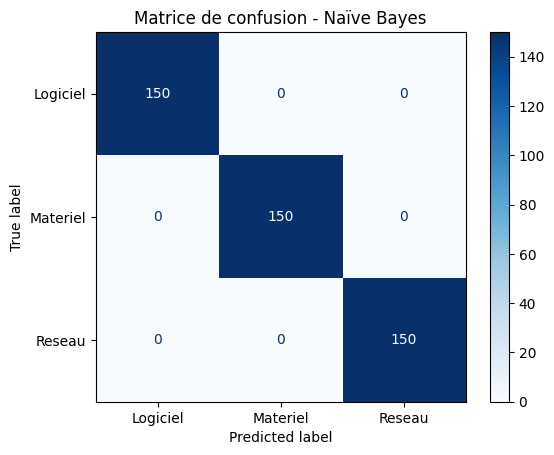

In [16]:
pred_nb = evaluate(pipe_nb, X_test, y_test, "Naïve Bayes")


===== Évaluation : Logistic Regression =====

              precision    recall  f1-score   support

    Logiciel       1.00      1.00      1.00       150
    Materiel       1.00      1.00      1.00       150
      Reseau       1.00      1.00      1.00       150

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450



<Figure size 600x400 with 0 Axes>

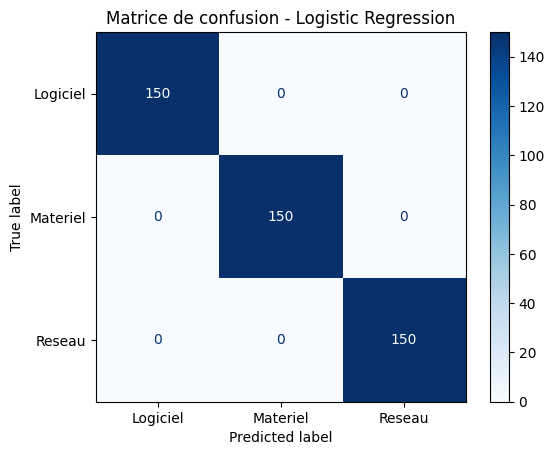

In [17]:
pred_lr = evaluate(pipe_lr, X_test, y_test, "Logistic Regression")

#Exemple de prédiction réelle

In [23]:
exemple = pd.DataFrame([
    {
        "ticket_text": "Utilisateur ne peut pas se connecter au logiciel métier..",
        "impact": "Élevé",
        "dayofweek": 2,
        "month": 11
    }
])

pred = pipe_lr.predict(exemple)
print("Catégorie prédite :", le.inverse_transform(pred)[0])

Catégorie prédite : Logiciel
